<a href="https://colab.research.google.com/github/roesta07/Survival-Models-in-Businesses/blob/main/Survival_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# # Note: Run this only when you have dependencies issues
# # Imports and utility functions
# # Install packages that are not installed in colab
# try:
#   import google.colab
#   IN_COLAB = True
# except:
#   IN_COLAB = False
 
# if IN_COLAB:
#     !pip install pymc3==3.11.2

#     !pip install theano==1.1.2
#     !pip install watermark
#     !pip install arviz==0.11.2
#     !pip install numpy==1.19.5
#     !pip install scipy==1.4.1

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import theano.tensor as tt
from scipy.special import expit


%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')


#Introduction

##Data

In [2]:
df=pd.read_csv("https://raw.githubusercontent.com/roesta07/Survival-Models-in-Businesses/main/data_generation/data.csv")
df.head()

,adm_date,dropped,days_at_school,far,bus
0,2019-01-01,1.0,675.0,1.0,1.0
1,2019-01-01,1.0,1027.0,0.0,0.0
2,2019-01-01,1.0,157.0,0.0,0.0
3,2019-01-01,1.0,177.0,0.0,0.0
4,2019-01-01,0.0,1824.0,0.0,0.0


#Problems and challenges


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


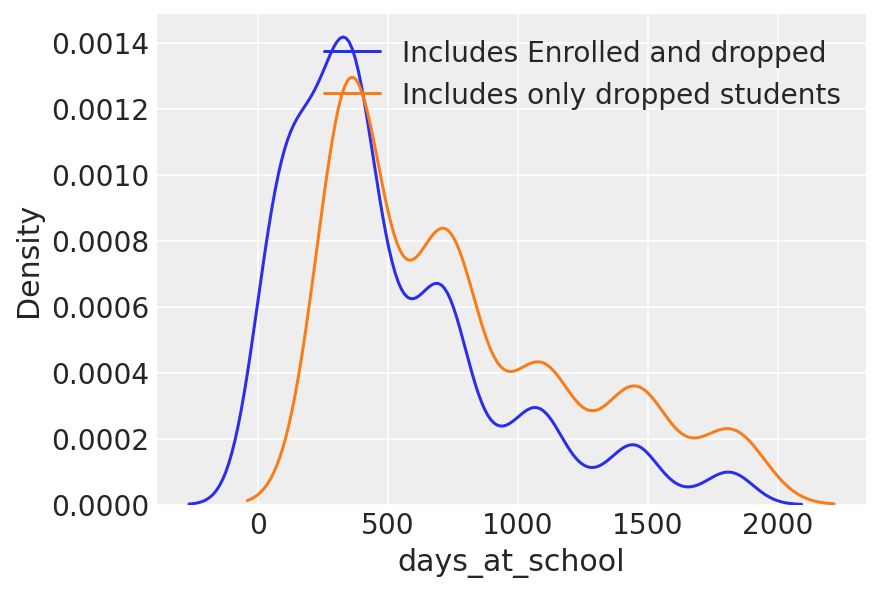

In [3]:
sns.distplot(df['days_at_school'],hist=False,label='Includes Enrolled and dropped')
sns.distplot(df.loc[df['dropped']==0,'days_at_school'],hist=False,label='Includes only dropped students')
plt.legend()

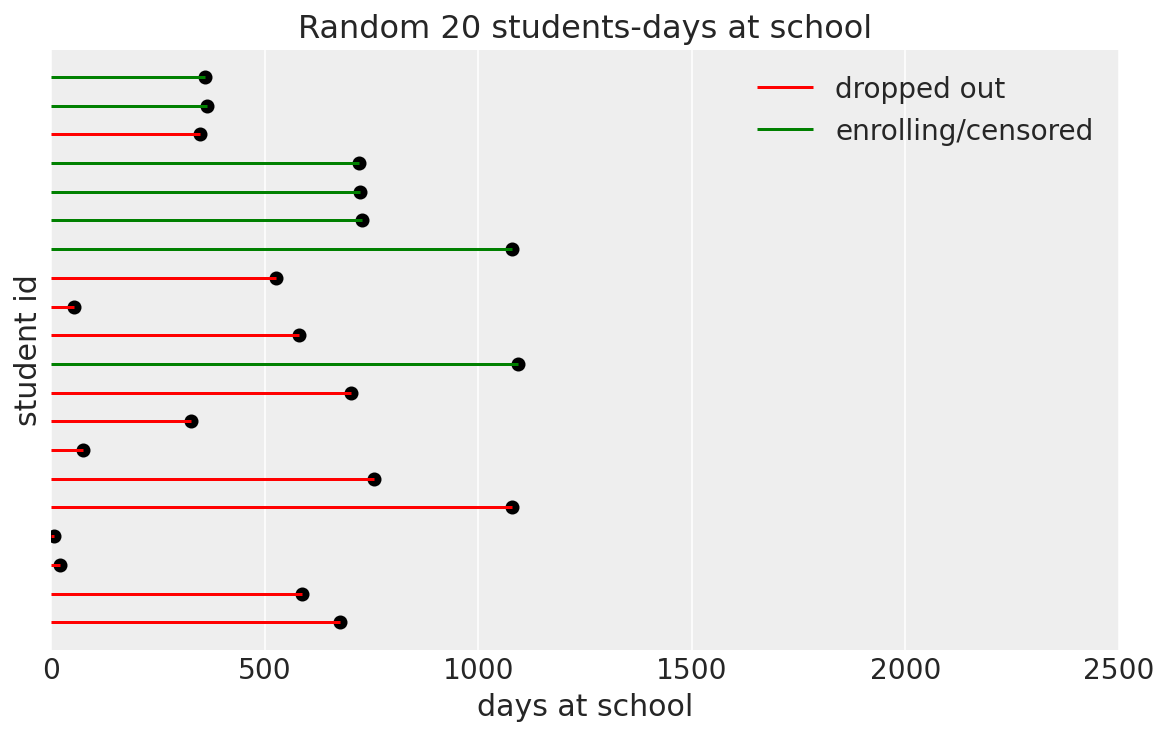

In [4]:
## first limit df to 10
d=df.loc[(df.index.values[:2000:100])]
dropped=d['dropped']==1
enrolling=~dropped

fig,ax=plt.subplots(figsize=(8,5))

ax.hlines(d.loc[dropped].index.values,xmin=0,xmax=d.loc[dropped,'days_at_school'],color='r',label='dropped out')
ax.hlines(d.loc[enrolling].index.values,xmin=0,xmax=d.loc[enrolling,'days_at_school'],color='g',label='enrolling/censored')
ax.scatter(
    d.loc[:,'days_at_school'],
    d.index.values,
    c='k',
)

ax.set(title='Random 20 students-days at school',xlabel='days at school',ylabel='student id',xlim=(0,2500),yticks=[])
plt.legend()

One problem with these types of analyses is that the dataset represents a certain time window. There will be a mix of students currently continuing and students who have dropped out in the dataset.This can create confusion as the students currently continuing their academics will still be in that dataset but we are interested in only drop-out rates and therefore an instinct will be to ***delete data*** of students who haven't dropped out.

But *this is a mistake* and can cause ***biased estimates*** because the students who have not dropped out until we download the data give us information about the dropout rate by representing that they haven't dropped out. 

This is confusing, but one loose example to understand this can be simple as; the probability of head gives us information about probability tail as they are *complementary* of each other.

# Exponential Distribution

Text(20, 0.8, 'probability of not-dropout\n before or at given day')

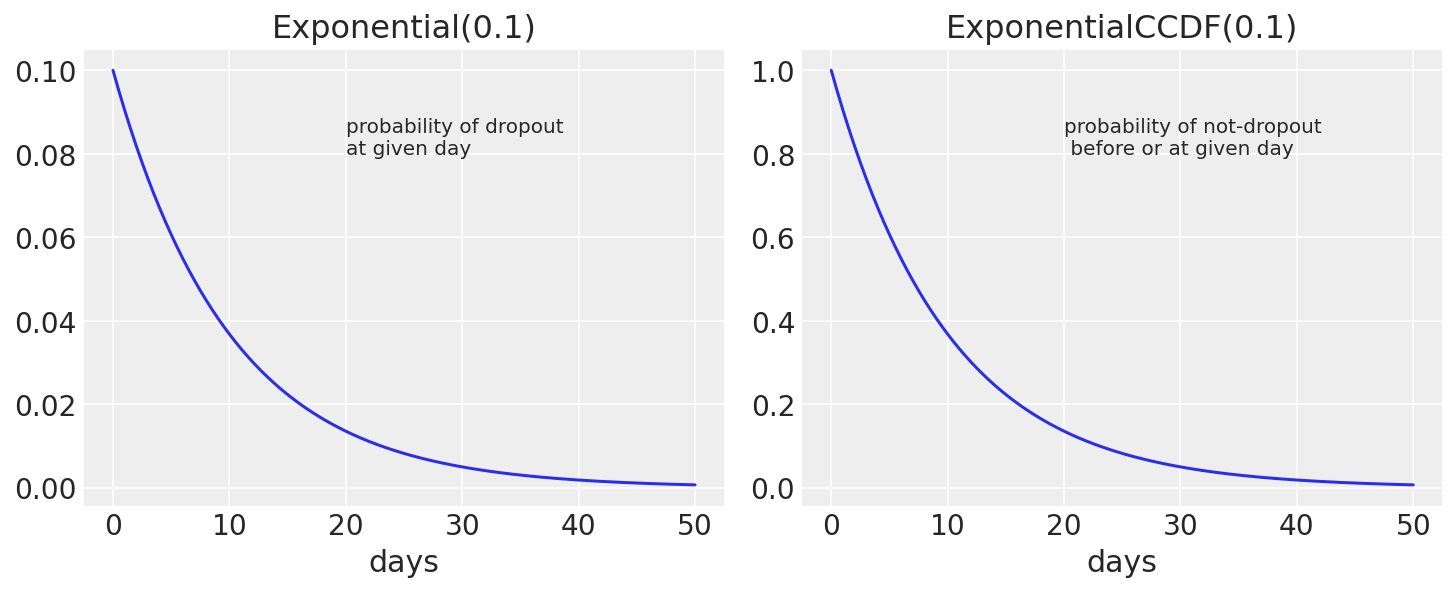

In [5]:
fig,axs=plt.subplots(1,2,figsize=(10,4))
eX=np.linspace(0,50,300)
lam=0.1
axs[0].plot(eX,stats.expon.pdf(eX,loc=0,scale=1/lam))    ## Exponential 
axs[1].plot(eX,(1-stats.expon.cdf(eX,loc=0,scale=1/0.1))) ## ExponentialCCDF
axs[0].set(title='Exponential(0.1)',xlabel='days',)
axs[1].set(title='ExponentialCCDF(0.1)',xlabel='days')

axs[0].text(20,0.08,'probability of dropout \nat given day')
axs[1].text(20,0.8,'probability of not-dropout\n before or at given day')

# Prior predective checks

In [6]:


def plot_priors(mu_prior,sd_prior,ax_0,ax_1):
  """
  plot priors for different values of a given
  mu and sd
  """

  if (ax_0==None) or (ax_1==None):
    fig,(ax_0,ax_1)=plt.subplots(2,1)

  a=stats.norm(mu_prior,sd_prior).rvs(100)
  b=stats.norm(mu_prior,sd_prior).rvs(100)
  mu=np.exp(a+b)
  lams=1/mu
  eX=np.arange(0,100)

  for lam in lams:
    eY=stats.expon.pdf(eX,loc=0,scale=1/lam)
    ax_0.plot(eX,eY)
  sns.distplot(lams,ax=ax_1)
  ax_0.set(xlim=(0,10),ylim=(0,0.25),xlabel='days',ylabel='rate ',title=f'a,b~Normal({mu_prior},{sd_prior})')
  ax_1.set(xlabel='rate',ylabel='density',title=f'a,b~Normal({mu_prior},{sd_prior})')

  


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

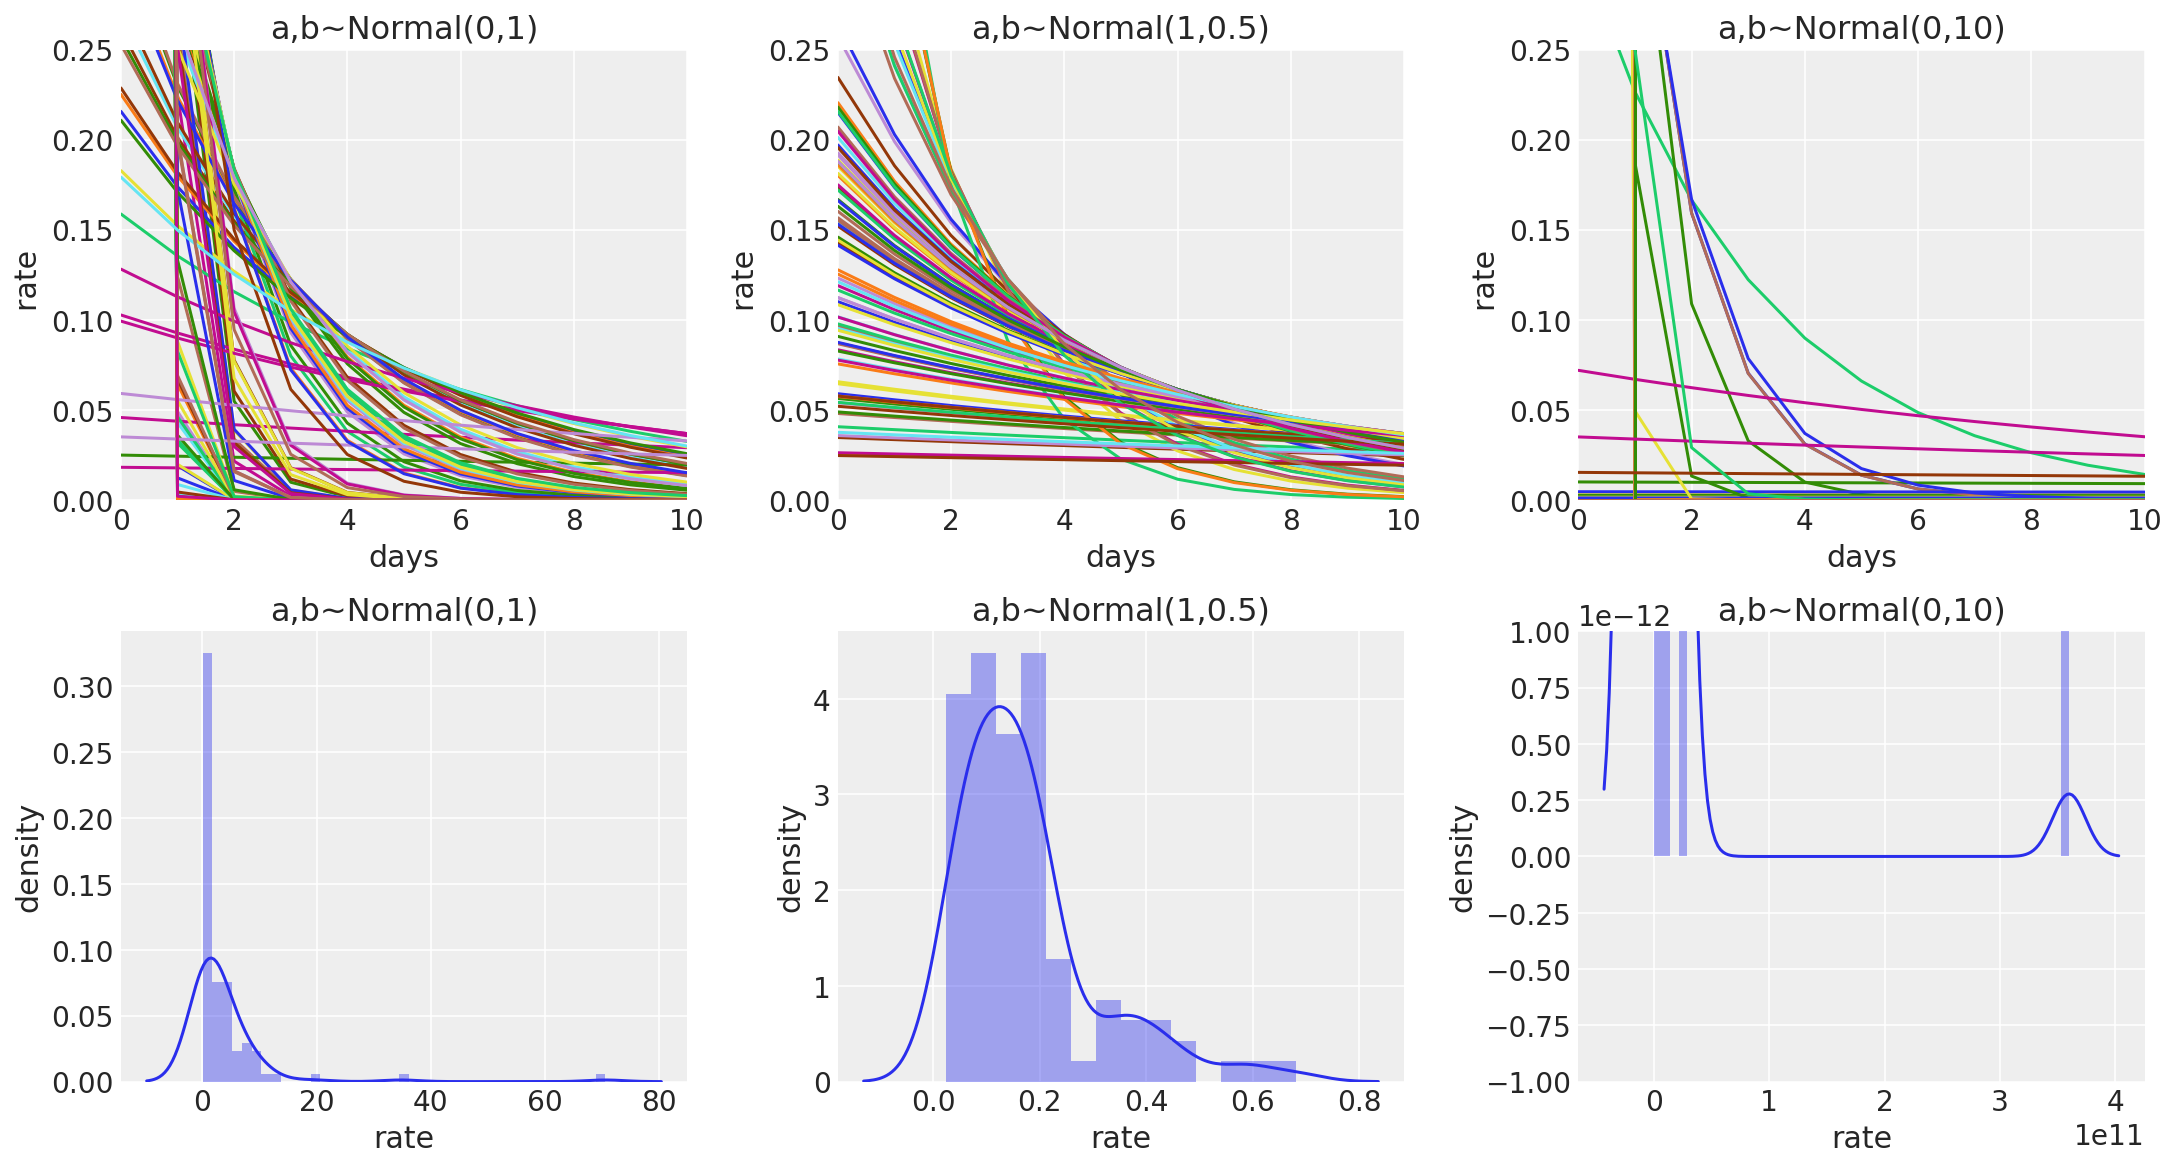

In [7]:
fig,axs=plt.subplots(2,3,figsize=(15,8))

plot_priors(0,1,axs[0,0],axs[1,0])

plot_priors(1,0.5,axs[0,1],axs[1,1])

plot_priors(0,10,axs[0,2],axs[1,2])

# Model


$$(D_{i}|dropout==1) \sim Exponential(\lambda_{i})$$
$$(D_{i}|dropout==0) \sim Exponential-CCDF(\lambda_{i})$$
where,
$$\lambda_{i}= \alpha_{[far]}+  \beta_{[bus]} $$
$$\alpha\sim Normal(1,1.5)$$
$$\beta \sim Normal(1,1.5)$$

$D_{i}$, days to event

$\lambda_{i}$, dropout rate

In [8]:
def likelihood(lam,obs_value,censored):
    return (censored*tt.log(lam) - lam * obs_value)

with pm.Model() as m_1:
  drop_out=pm.Data('drop_out',df['dropped'])
  far=pm.Data('far',df['far'].astype('int'))
  days_at_school=pm.Data('days_at_school',df['days_at_school'])
  bus=pm.intX(pm.Data('bus',df['bus']))
  a=pm.Normal('a',2,0.5,shape=2)
  b=pm.Normal('b',2,0.5,shape=2)
  mu = pm.Deterministic('mu',pm.math.exp(a[far]+b[bus]))
  lam= pm.Deterministic('lam',1/mu)
  drop_out_rate=pm.Potential('drop_out_rate',likelihood(lam=lam,obs_value=days_at_school,censored=drop_out))
  trace_1=pm.sample(return_inferencedata=True,cores=2)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 28 seconds.
The number of effective samples is smaller than 25% for some parameters.


## Traces and convergenges


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4ce1d75f90>,
      dtype=object)

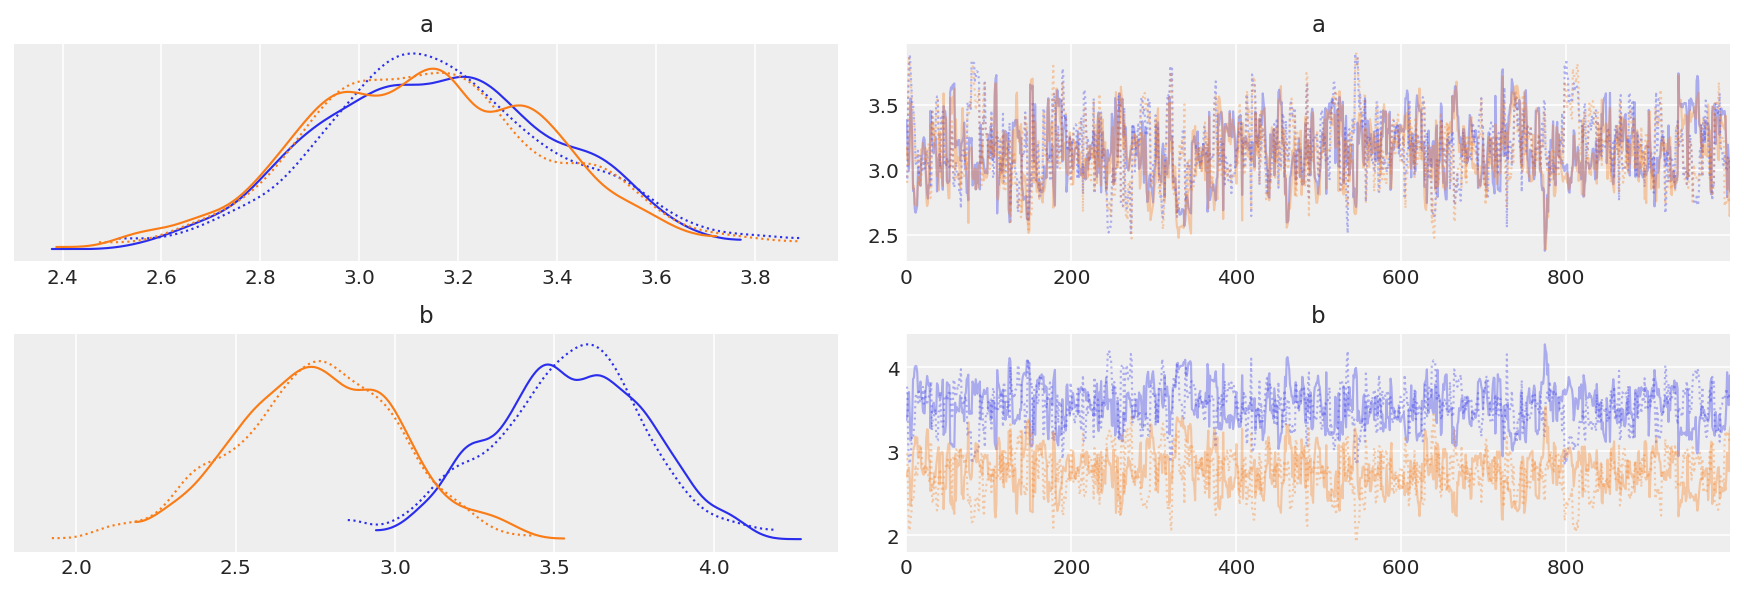

In [ ]:
az.plot_trace(trace_1,var_names=['~lam','~mu'])

In [ ]:
az.summary(trace_1,var_names=['~lam','~mu'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],3.164,0.245,2.697,3.613,0.014,0.01,288.0,384.0,1.01
a[1],3.137,0.249,2.686,3.608,0.015,0.01,292.0,346.0,1.01
b[0],3.540,0.244,3.056,3.970,0.015,0.01,279.0,380.0,1.01
b[1],2.756,0.252,2.302,3.246,0.015,0.01,300.0,347.0,1.01


In [ ]:

az.summary(
  {
  'lambda|far,no_bus':(1/np.exp(trace_1.posterior.sel({'a_dim_0':1,'chain':0})['a'].data+trace_1.posterior.sel({'b_dim_0':0,'chain':0})['b'].data)),
  'lambda|far,bus':(1/np.exp(trace_1.posterior.sel({'a_dim_0':1,'chain':0})['a'].data+trace_1.posterior.sel({'b_dim_0':1,'chain':0})['b'].data))
  },
  kind='stats'
)

,mean,sd,hdi_3%,hdi_97%
"lambda|far,no_bus",0.001,0.0,0.001,0.002
"lambda|far,bus",0.003,0.0,0.003,0.003


# Posterior Predective

In [14]:
with m_1:
  pm.set_data({'far':np.array([1,1]),'bus':np.array([0,1])})
  posterior_1=pm.sample_posterior_predictive(trace_1,var_names=['mu'])

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1701: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  UserWarning,


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

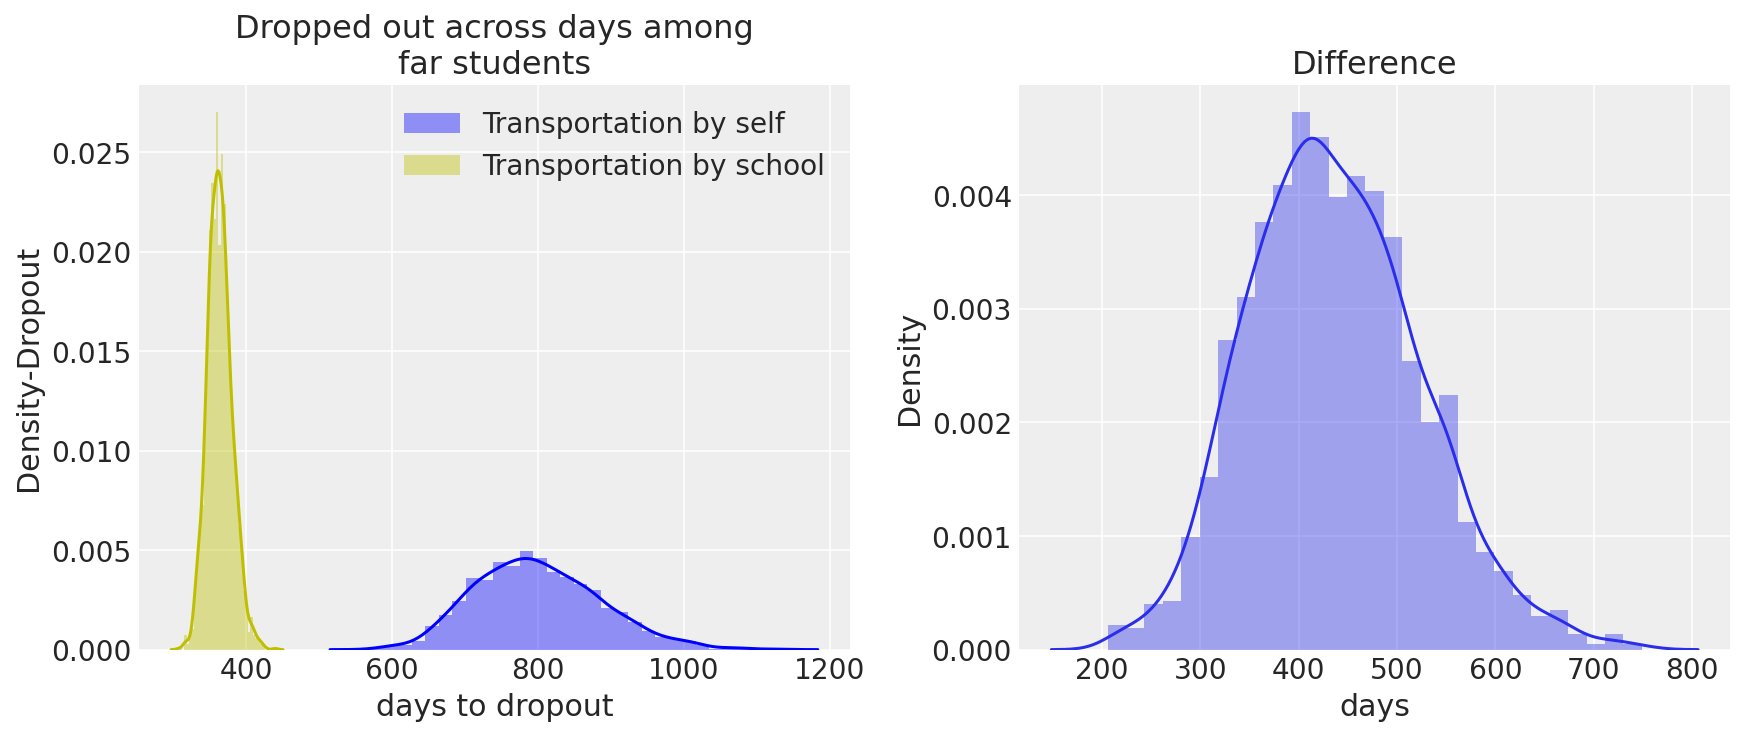

In [16]:
fig,axs=plt.subplots(1,2,figsize=(12,5))
sns.distplot(posterior_1['mu'][:,0],color='b',ax=axs[0],label='Transportation by self')
sns.distplot(posterior_1['mu'][:,1],color='y',ax=axs[0],label='Transportation by school',)
sns.distplot(posterior_1['mu'][:,0]-posterior_1['mu'][:,1])
axs[0].set(title='Dropped out across days among\nfar students',xlabel='days to dropout',ylabel='Density-Dropout')
axs[1].set(title='Difference',xlabel='days',)
axs[0].legend()